# Import Libraries

In [13]:
import os
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import np_utils
from collections import Counter, OrderedDict
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Read & Store Image

In [2]:
SIZE = 225

images = []
labels = []

for folder_path in glob.glob("Flower/*"):
    for img_path in glob.glob(folder_path + "/*"):
        img_path = img_path.replace('\\', '/')
        label = img_path.split('/')[-2]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))

        images.append(img)
        labels.append(label)

In [18]:
print(len(images))
print(len(labels))

4317
4317


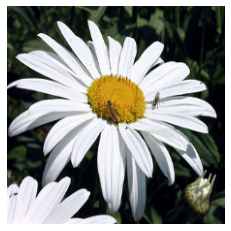

daisy


In [19]:
plt.imshow(images[123])
plt.axis('Off')
plt.show()
print(labels[123])

# Prepare Train & Test Sets

In [3]:
# Shuffle
temp = list(zip(images, labels))
random.Random(42).shuffle(temp)
res1, res2 = zip(*temp)
images, labels = list(res1), list(res2)

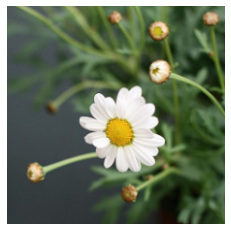

daisy


In [21]:
plt.imshow(images[123])
plt.axis('Off')
plt.show()
print(labels[123])

In [4]:
# Train test stratified split
img_train, img_test, label_train, label_test = train_test_split(images, labels, stratify=labels, test_size=0.2, random_state=11)

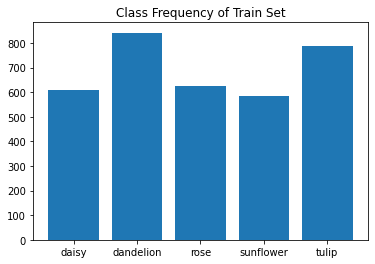


Train Set
daisy: 611 (17.69%)
dandelion: 842 (24.38%)
rose: 627 (18.16%)
sunflower: 586 (16.97%)
tulip: 787 (22.79%)


In [23]:
# Plot Class Freqeuncy of Train Set
c_train = OrderedDict(sorted(Counter(label_train).items()))
plt.bar(c_train.keys(), c_train.values())
plt.title("Class Frequency of Train Set")
plt.show()

print("\nTrain Set")
for i, v in enumerate(c_train):
  print(f"{v}: {c_train[v]} ({round(c_train[v]/sum(c_train.values())*100,2)}%)")

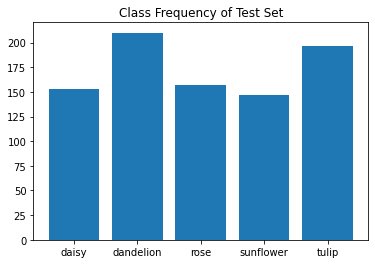


Test Set
daisy: 153 (17.71%)
dandelion: 210 (24.31%)
rose: 157 (18.17%)
sunflower: 147 (17.01%)
tulip: 197 (22.8%)


In [24]:
# Plot Class Freqeuncy of Train Set
c_test = OrderedDict(sorted(Counter(label_test).items()))
plt.bar(c_test.keys(), c_test.values())
plt.title("Class Frequency of Test Set")
plt.show()

print("\nTest Set")
for i, v in enumerate(c_test):
  print(f"{v}: {c_test[v]} ({round(c_test[v]/sum(c_test.values())*100,2)}%)")

# Convert to np array

In [5]:
img_train = np.array(img_train, dtype="float")
img_test = np.array(img_test, dtype="float")
label_train = np.array(label_train)
label_test = np.array(label_test)

# After conversion
print("X_train: ", "type-", type(img_train), "; size-", img_train.shape)
print("y_train: ", "type-", type(label_train), "; size-", label_train.shape)

X_train:  type- <class 'numpy.ndarray'> ; size- (3453, 225, 225, 3)
y_train:  type- <class 'numpy.ndarray'> ; size- (3453,)


# Label Encoding

In [6]:
le = preprocessing.LabelEncoder()
le.fit(label_train)

label_encoded_train = le.transform(label_train)
label_encoded_test = le.transform(label_test)

In [28]:
le.classes_

array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype='<U9')

# One Hot Encoding

In [7]:
n_classes = len(le.classes_)

print("Shape before OHE: ", label_encoded_train.shape)

label_encoded_train = np_utils.to_categorical(label_encoded_train,n_classes)
label_encoded_test = np_utils.to_categorical(label_encoded_test,n_classes)

print("Shape after OHE: ", label_encoded_train.shape)

Shape before OHE:  (3453,)
Shape after OHE:  (3453, 5)


# Normalization

In [8]:
img_train, img_test = img_train/255.0, img_test/255.0

# Model Training

In [44]:
seed_value = 11
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [45]:
early = EarlyStopping(monitor="loss", 
                      mode="min", 
                      patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

filepath = "flower_classifier.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy',   
                             verbose=1, save_best_only=True, mode='max', save_weights_only=True)

callbacks_list = [early, checkpoint, reduce_lr]

In [46]:
datagen = ImageDataGenerator(width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

In [47]:
feature_extractor = tf.keras.applications.VGG19(weights='imagenet',
                             input_shape=(SIZE, SIZE, 3),
                             include_top=False)
feature_extractor.trainable = False

input_ = tf.keras.Input(shape=(SIZE, SIZE, 3))
x = feature_extractor(input_, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output_ = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(datagen.flow(img_train, label_encoded_train, batch_size=24), 
          epochs=50, 
          steps_per_epoch=img_train.shape[0]//24,
          validation_data=(img_test, label_encoded_test),
          callbacks=callbacks_list)



80134624/80134624 [==============================] - 23s 0us/step
Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 1.2105 - accuracy: 0.5605
Epoch 1: accuracy improved from -inf to 0.56051, saving model to flower_classifier.h5
143/143 [==============================] - 75s 504ms/step - loss: 1.2105 - accuracy: 0.5605 - val_loss: 0.8830 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.8460 - accuracy: 0.7017
Epoch 2: accuracy improved from 0.56051 to 0.70166, saving model to flower_classifier.h5
143/143 [==============================] - 67s 468ms/step - loss: 0.8460 - accuracy: 0.7017 - val_loss: 0.7277 - val_accuracy: 0.7280 - lr: 0.0010
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.7537 - accuracy: 0.7329
Epoch 3: accuracy improved from 0.70166 to 0.73287, saving model to flower_classifier.h5
143/143 [==============================] - 67s 467ms/step - loss: 0.7537 - accuracy: 0.7

# Evaluation

In [26]:
feature_extractor = tf.keras.applications.VGG19(weights=None,
                             input_shape=(SIZE, SIZE, 3),
                             include_top=False)
feature_extractor.trainable = False

input_ = tf.keras.Input(shape=(SIZE, SIZE, 3))
x = feature_extractor(input_, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output_ = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

model.load_weights('flower_classifier.h5')

pred = [i.argmax() for i in model.predict(img_test)]
pred = le.inverse_transform(pred)
accuracy_score(label_test, pred)

27/27 [==============================] - 11s 422ms/step


0.8067129629629629

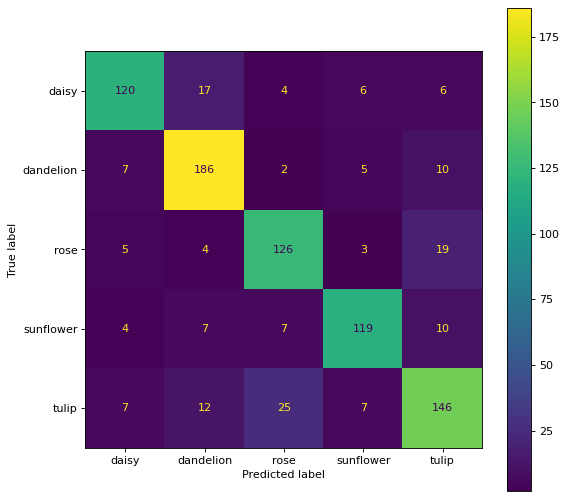

In [25]:
cm = confusion_matrix(label_test, pred, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8), dpi=80)
disp.plot(ax=ax)